# NLP project


Project 21: Automatic Summarization  

We shall consider structured document containing a title, abstract and a set of subsections. We would like to build a text summarizer such that tracks important keywords in the document. For this purpose, the first step is identify these keywords.  

In [1]:
pip install --upgrade pip

In [2]:
!pip list
# tarkista löytyykö: lxml, html5lib, requests, selenium, webdriver-manager
# lisäohjeita task1

Package            Version
------------------ ---------
aiohttp            3.6.2
astroid            2.3.3
async-generator    1.10
async-timeout      3.0.1
atomicwrites       1.3.0
attrs              19.3.0
autopep8           1.5
backcall           0.1.0
beautifulsoup4     4.8.2
bleach             3.1.3
blis               0.7.4
catalogue          2.0.6
certifi            2019.6.16
cffi               1.14.0
chardet            3.0.4
click              8.0.1
colorama           0.4.1
configparser       5.0.2
coverage           5.0.3
crayons            0.4.0
cryptography       35.0.0
cycler             0.10.0
cymem              2.0.5
decorator          4.4.2
defusedxml         0.6.0
discord.py         1.5.1
en-core-web-sm     3.1.0
entrypoints        0.3
ffmpeg             1.4
ffmpeg-python      0.2.0
flake8             3.7.9
flake8-polyfill    1.0.2
future             0.17.1
graphviz           0.13.2
h11                0.12.0
idna               2.8
importlib-metadata 1.5.0
ipykernel        

In [3]:
#jos nltk ei löydy asenna -> ! pip install nltk
import nltk
nltk.download("stopwords")
#from nltk.cluster.util import cosine_distance

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lassi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## TASK 1
Assume the initial input is given as html document (choose an example of your own), we hypothesize that important keywords are initially contained in the words of titles, abstract and possibly titles of subsections of the document. Suggest a simple python script that inputs an html document and outputs the lists of words in the title, abstract and title of section/subsections.

In [4]:
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time
# Kaikki sivut ei anna koko html bodyä käyttämällä pelkkää requestia. Seleniumilla näyttää toimivan useammilla. 
# pip install -U selenium
# pip install webdriver-manager
# jos käytät anacondaa eikä meinaa toimia niin kokeile myös $ conda update pip

#Collect title, subtitles and abstract from html file

url = "https://ieeexplore.ieee.org/document/6809191"
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(url)

# Wait for page to fully load
time.sleep(3)

soup = BeautifulSoup(driver.page_source, 'lxml')
print(soup)

# Headline
headline = soup.find("h1", {"class": "document-title"}).text
print("Headline: {}\n".format(headline))

# Abstact
abstract = soup.find("div", {"class": "abstract-text"}).text
print("{}\n\n".format(abstract))

# Titles of sections
article = soup.find("div", {"id": "article"})
if article == None:
    print("Article is None")
# Saattaa joskus heittää erroria article = None, kokeilee vaan uudestaan niin pitäis toisella kertaa mennä
sectionTitles = article.find_all("h3")
secTitles = ""
print("Section titles:")
for title in sectionTitles:
    print("{}".format(title.text))
    secTitles += title.text
    secTitles += ".\n"

# Titles of subsections
subsectionTitles = article.find_all("h4")
subsecTitles = ""
print("\nSubsection titles:")
for title in subsectionTitles:
    print("{}".format(title.text))
    subsecTitles += title.text
    subsecTitles += ".\n"
    
driver.close()

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Driver [C:\Users\Lassi\.wdm\drivers\chromedriver\win32\94.0.4606.61\chromedriver.exe] found in cache
c:\program files (x86)\python 3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  del sys.path[0]


<html class="js postmessage history draganddrop borderimage borderradius boxshadow textshadow cssgradients csstransforms csstransforms3d csstransitions generatedcontent localstorage sessionstorage" lang="en-US"><head><style type="text/css">@charset "UTF-8";[ng\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide:not(.ng-hide-animate){display:none !important;}ng\:form{display:block;}.ng-animate-shim{visibility:hidden;}.ng-anchor{position:absolute;}</style><script async="" src="//tags.tiqcdn.com/utag/ieeexplore/main/prod/utag.js" type="text/javascript"></script><script async="" src="https://securepubads.g.doubleclick.net/tag/js/gpt.js" type="text/javascript"></script><script type="text/javascript">

var home = {	
			metadata:{
				searchCount: '5 441 856',
				logoRelPath: '/customer_logos',
				thirdParthAuth: false,
				currentPage:  'document',
				xploreVirtual:'https://ieeexplore.ieee.org',
				isWebAccount: false,
				isProvisioned: false,
				globalNotifi

In [5]:
paragraphs = article.find_all("p")
fullText = ""
for paragraph in paragraphs:
    fullText += paragraph.text
    fullText += "\n"
print(fullText)

The most computationally expensive part of many computer vision algorithms consists of searching for the most
 similar matches to high-dimensional vectors, also referred to as nearest neighbor matching. Having an efficient
 algorithm for performing fast nearest neighbor matching in large data sets can bring speed improvements of several
 orders of magnitude to many applications. Examples of such problems include finding the best matches for local image
 features in large data sets [1][2]
 clustering local features into visual words using the k-means or similar algorithms 
[3], global image feature matching for scene recognition [4], human pose
 estimation [5], matching deformable shapes for object recognition 
[6] or performing normalized cross-correlation (NCC) to compare image patches
 in large data sets [7]. The nearest neighbor search problem is also of major
 importance in many other applications, including machine learning, document retrieval, data compression,
 bio-informatics, 

In [6]:
import yake

In [7]:
#Keyword search and analysis

w_extractor = yake.KeywordExtractor()

language = "en"
max_ngram_size = 2
deduplication_threshold = 0.9
numOfKeywords = 50 #alunperin 10

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(fullText)

for kw in keywords:
    print(kw)


('nearest neighbor', 0.0007739688712301222)
('neighbor search', 0.0009503782138231184)
('search', 0.0011044997218029166)
('data set', 0.0013119207281173436)
('data', 0.0016701477799471959)
('data sets', 0.0016928009395062499)
('tree', 0.002426773084668302)
('neighbor', 0.002810793232121408)
('nearest', 0.0029959302621123123)
('k-means tree', 0.003018122090799451)
('search k-means', 0.0030622822383677343)
('priority search', 0.003853565098016841)
('algorithm', 0.00412486789852908)
('set', 0.00516323692480795)
('search time', 0.005944471677938913)
('search performance', 0.00624056909979162)
('trees', 0.006575772229423787)
('algorithms', 0.00721851882242589)
('neighbors', 0.007495448618990421)
('View Source', 0.007506356094694769)
('theta', 0.0075558336407760785)
('search algorithms', 0.00784823011789166)
('sets', 0.007906206541112171)
('neighbor algorithm', 0.00817335413921152)
('approximate nearest', 0.008638424696864782)
('k-means', 0.009015421379539442)
('approximate search', 0.009369

## TASK 2
Write down a simple python script that allows you to output the histogram of word frequency in the document, excluding the stopwords (see examples in online NLTK book). Use SpaCy named-entity tagger to identify person-named entities and organization-named entities in the document.

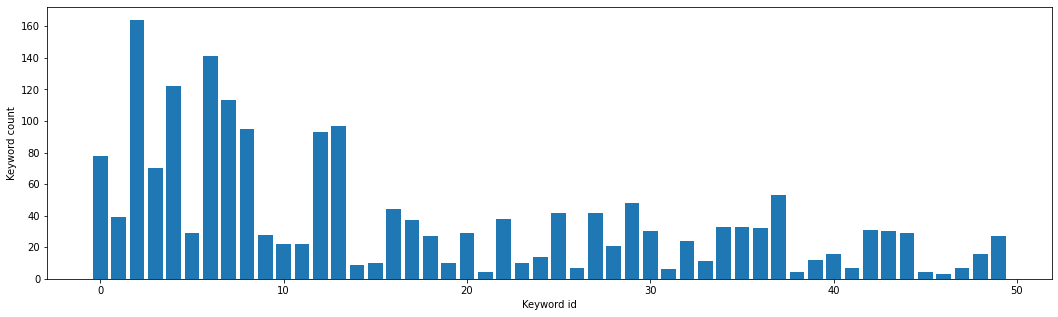

In [8]:
#from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

#Calculate the word frequencies and plot the histogram

#Purkkapallolla koko artikkeli -> string
article_readable = "{}\n".format(headline)

#article_readable += (article.find('div', class_="article-content").h1.text) + " "
article_readable += "{}\n".format(abstract)

for sectionTitle in sectionTitles:
    article_readable += "{} ".format(sectionTitle.text)

for subsectionTitle in subsectionTitles:
    article_readable += "{} ".format(subsectionTitle.text)
    
article_readable += "\n{}".format(fullText)
    
#print(article_readable)
#Purkkapallo suoritettu

stopwords = stopwords.words("english")
#print(stopwords)

#Remove stopwords from the keywords list
keywords_only, keywords_nums = zip(*keywords) 
keywords_no_sw =  [word for word in keywords_only if not word in stopwords]
keywords_counts = []

for kw in keywords_no_sw:
    kw_count = article_readable.count(kw)
    keywords_counts.append(kw_count)

#print(keywords_no_sw)
#print(keywords_counts)
    
#Plotting the histogram
fig, ax = plt.subplots(figsize=(18,5))
plt.bar(np.arange(len(keywords_no_sw)), keywords_counts, align='center')
plt.ylabel('Keyword count')
plt.xlabel('Keyword id')
plt.show()


('search', 152)
('data', 124)
('nearest', 90)
('tree', 86)
('neighbor', 82)
('algorithm', 65)
('using', 58)
('set', 51)
('k-means', 43)
('performance', 42)
('algorithms', 40)
('time', 36)
('trees', 35)
('sets', 34)
('randomized', 34)
('used', 34)
('approximate', 33)
('number', 33)
('memory', 31)
('priority', 30)
('points', 30)
('clustering', 28)
('show', 28)
('neighbors', 28)
('features', 27)
('query', 27)
('k-d', 26)
('matching', 25)
('large', 24)
('fig', 24)
('multiple', 23)
('point', 23)
('case', 22)
('hierarchical', 21)
('many', 20)
('cluster', 20)
('different', 19)
('one', 18)
('dimensionality', 18)
('parameter', 18)
('use', 18)
('lsh', 18)
('hashing', 17)
('speedup', 17)
('also', 16)
('distributed', 16)
('source', 16)
('flann', 16)
('patches', 16)
('found', 16)


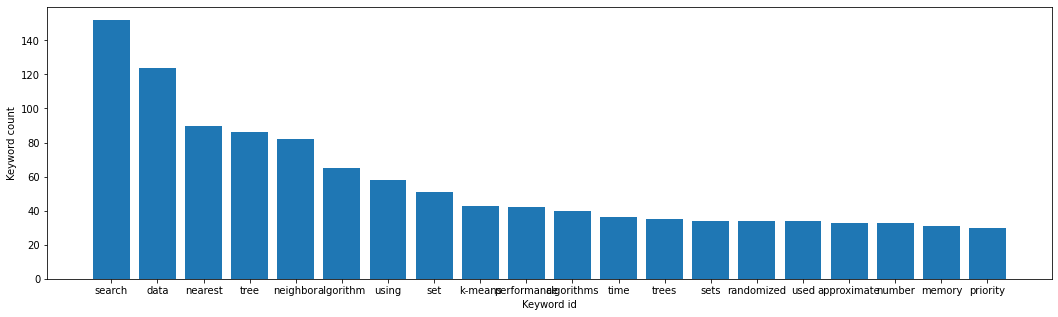

In [13]:
### Count histogram from every word manually ###
charsToRemove = ".,():"
for char in charsToRemove:
    article_readable = article_readable.replace(char, '')

article_readable = article_readable.lower()
wordList = article_readable.split()
wordList = [word for word in wordList if word not in stopwords]
wordCounts = dict()

for word in wordList:
    if word in wordCounts:
        wordCounts[word] += 1
    else:
        wordCounts[word] = 1

wordCounts = sorted(wordCounts.items(), key=lambda x: x[1], reverse=True)
for i in range(50):
    print("{}".format(wordCounts[i]))
wordCounts = wordCounts[0:20]

words = list(zip(*wordCounts))[0]
occurency = list(zip(*wordCounts))[1]
fig, ax = plt.subplots(figsize=(18,5))
plt.bar(np.arange(len(words)), occurency, align='center')
plt.xticks(np.arange(len(words)), words)
plt.ylabel('Keyword count')
plt.xlabel('Keyword id')
plt.show()

In [15]:
#Use SpaCy to identify person-named entities and organization-named entities
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

#vinkkiä https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

#Identifying person and organization-named entities
nlp = en_core_web_sm.load()
doc = nlp(article_readable)

#Print only ORG or PERSON labeled entities
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == "ORG" or ent.label_ == "PERSON":
                print(ent.text+ " - " + ent.label_)
    else:
        print("No named entities found.")
        
show_ents(doc)

"""
for X in doc.ents:
    print("{} - {}".format(X.text, X.label_))
"""


\bb - ORG
min_{x\in p}\ - ORG
min_{x\in p}\ - ORG
\rm knn}qpk - PERSON
\rm knn}qpk - PERSON
\vert a\vert - PERSON
\vert a\vert = k - PERSON
\in - ORG
\in - ORG
{\rm rknn}qpkr - PERSON
{\rm rknn}qpkr - PERSON
\vert a\vert \le - PERSON
\vert a\vert \le - PERSON
\in - ORG
dqx\le dqy - PERSON
\in - ORG
dqx\le dqy - PERSON
wang
  - PERSON
k\$ - PERSON
\$l/ - PERSON
n / \log\ - PERSON
k\$ inner - PERSON
\log\ - PERSON
k\$ - PERSON
\in - ORG
m_d\$ - PERSON
fedora arch - PERSON


'\nfor X in doc.ents:\n    print("{} - {}".format(X.text, X.label_))\n'

## TASK 3

We would like the summarizer to contain frequent wording (excluding stopwords) and as many named-entities as possible. For this purpose, use the following heuristic to construct the summarizer. First we shall assume each sentence of the document as individual sub-document. Use TfIdf vectorizer to output the individual tfidef score of each word of each sentence (after initial preprocessing and wordnet lemmatization stage). Then consider only sentences that contain person or organization named-entities and use similar approach to output the tfidf score of the named-entities in each sentence. Finally construct the sentence (S) weight as a  weighted sum:
<br>
$$S_{weight}=\sum_{w\varepsilon S}W_{TfiDf}+2\sum_{NM\varepsilon S}NM_{TfiDf}+POS_s$$
<br>
where NMTfiDF stands for the TfIdF of named-entity NM in sentence S.  POSS corresponds to the sentence weight associated to the location of the sentence. So that the sentence location weight will be maximum (1) if located in the title of the document, 0.5 if located  in the title of one of the subsection, 0.25 if located in the title one of the subsubsection, 0.1 if located in one representative object of the document, and 0 if located only in the main text. Make sure to normalize the term tfidf and Nm tfidf weights and suggest a script to implement the preceding accordingly, so that the summarizer will contain the 10 sentences with the highest Sweight scores.  


In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lassi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lassi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
weights = {
    "title": 1,
    "sectionTitle": 0.5,
    "subsectionTitle": 0.25,
    "abstract": 0.1,
    "else": 0.0
}

In [ ]:
# Preprocess
def preProcess(document):
    stopwords = list(set(nltk.corpus.stopwords.words('english')))
    stemmer = SnowballStemmer("english")
    WN_lemmatizer = WordNetLemmatizer()

    sentences = sent_tokenize(document)
    #print(sentences)
    # List of lemmatized words for each sentence
    tokens = []
    tokensInSentences = []
    processedSentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [WN_lemmatizer.lemmatize(word, pos="v") for word in words]

        # get rid of numbers and Stopwords
        words = [word for word in words if word.isalpha() and word not in stopwords]
        tokens.extend(words)
        tokensInSentences = ([words])
        processedSentences.append(' '.join(word for word in words))

    #print(len(lauseet))
    #print(lauseet[0])
    return tokens, tokensInSentences, processedSentences
    

In [ ]:
def tfidf(corpus, position):
    Tfidf = TfidfVectorizer(use_idf=True)
    #Tfidf.fit(word_count_vecotr)
    fitted_vectorizer = Tfidf.fit(corpus)
    first_vector_tfidfvectorizer = fitted_vectorizer.transform(corpus).toarray()
    feature_names = Tfidf.get_feature_names()

    #print(len(feature_names))
    #print(feature_names)
    #print(first_vector_tfidfvectorizer.shape)
    scores = []
    #print(first_vector_tfidfvectorizer)
    for i in range(len(first_vector_tfidfvectorizer)):
        score = 0
        for j in range(len(first_vector_tfidfvectorizer[i])):
            score = score + first_vector_tfidfvectorizer[i][j]

        scores.append((i, score + weights[position]))

    return(scores)

In [ ]:
# Title
tokens, tokensInSentences, processedSentences = preProcess(headline)
tfidfScores = tfidf(processedSentences, "title")
print("{}\n".format(tfidfScores))

# Section title
tokens, tokensInSentences, processedSentences = preProcess(secTitles)
tfidfScores = tfidf(processedSentences, "sectionTitle")
print("{}\n".format(tfidfScores))

# Subsection title
tokens, tokensInSentences, processedSentences = preProcess(subsecTitles)
tfidfScores = tfidf(processedSentences, "subsectionTitle")
print("{}\n".format(tfidfScores))

# Abstract
tokens, tokensInSentences, processedSentences = preProcess(abstract)
tfidfScores = tfidf(processedSentences, "abstract")
print("{}\n".format(tfidfScores))

# Text body
tokens, tokensInSentences, processedSentences = preProcess(fullText)
tfidfScores = tfidf(processedSentences, "else")
print("{}\n".format(tfidfScores))


## TASK 4
Test the above approach with Opinosis dataset available at https://kavita-ganesan.com/opinosis-opinion-dataset/#.YVw6J5ozY2x,  and record the corresponding Rouge-2 and Rouge-3 evaluation score. 

In [ ]:
Rouge-3 ei edes mainita paperissa mikä on linkitetty, eli mitä sillä haetaan???? 
Paperissa on Rouge-1,Rouge-2 ja Rouge-SU4
Jos  sillä meinataan trigram metodia -> annettu koodi ei toimi sillä tavalla 

In [ ]:
#Rouge 2 ja 3 scoring
https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460

In [ ]:
"""
http://kavita-ganesan.com/opinosis-text-summarization-web-api/

The nice thing with using the REST API version versus the Java jar file is that you can integrate the API 
into your code base, making evaluation and the ability to build on the API output much easier. 
Please follow these steps to start using the API:

1. Create a Mashape (EI toimi enään!!!) account (Mashape manages API keys and access) and subscribe to the basic plan of this API. The usage is free up to a certain limit.
2. You can use the examples below to start using the Opinosis Web API
3. You can use this page to learn how to set the opinosis parameters.
"""


#Ei toimi, API servereitä ei ole enään olemassa, Pitää käyttää java sen sijaan että saadaan Rouge arvot ulos

# http://kavita-ganesan.com/opinosis-summarizer-library/  <-------

response = unirest.post("https://rxnlp-opinosis.p.mashape.com/generateOpinosisSummaries",
  headers={
    "X-Mashape-Key": "API-Key",
    "Content-Type": "application/json",
    "Accept": "application/json"
  },
  params=("{'maxGap':'3','maxSentences':'5','minRedundancy':'2','doCollapse':'true','scoringFunction':'3','text':[{'sentence':'the/DT bathroom/NN was/VBD clean/JJ and/CC the/DT bed/NN was/VBD comfy/JJ ./.'},{'sentence':'the/DT bathroom/NN was/VBD clean/JJ and/CC the/DT bed/NN was/VBD comfy/JJ ./.'},{'sentence':'the/DT bed/NN was/VBD comfy/JJ and/CC bathroom/NN was/VBD clean/JJ ./.'},{'sentence':'the/DT bathroom/NN was/VBD dirty/JJ ./.'},{'sentence':'the/DT bathroom/NN was/VBD dirty/JJ ./.'},{'sentence':'the/DT bathroom/NN was/VBD dirty/JJ ./.'},{'sentence':'the/DT bathroom/NN was/VBD dirty/JJ ./.'},{'sentence':'the/DT bathroom/NN was/VBD too/RB dirty/JJ ./.'}]}")
)

## TASK 5

We would like to improve the summarization by taking into account the diversity among the sentence in the sense that we would like to minimize redundancy among sentences. For this purpose, we shall use the sentence-to-sentence semantic similarity introduced in the NLP lab. 

Next, instead of recording only the 10 sentences with highest Sweight scores, we shall record the 20 top sentences in terms of $S_{weight}$ scores. Then the selection of the top 10 sentences among the 20 sentences follows the following approach. 

First, order the 20 sentences in the decreasing order of their $S_{weight}$ scores, say S1, S2, …, S20 (where S1 is the top ranked and S20 the 20th ranked sentence). 

Second, we shall assume that S1 is always included in the summarizer, we shall then attempt to find the other sentences among S2 till S20 to be included into the summarizer. 

Calculate the sentence-to-sentence similarity Sim(S1,Si) for i=1 to 20, the Sentence Sj that yields the minimum similarity with S1 will therefore be included in the summarizer. Next, for each of the remaining sentences Sk (with k different from 1 and j), we calculate the sentence similarity with Sj. Therefore the sentence Sp that yields minimum value of “Sim(Sp, S1)+Sim(Sp,Sj)” will be included in the summarizer (Note: the quantity Sim(Sp, S1) is already calculated in previous step).  

Similarly in the next phase, we should select a sentence Sl (l different from 1, j and k) so that  “Sim(Sl, S1)+Sim(Sl,Sj)+Sim(Sl,Sp)”, Etc.. You then stop once you reached 10 sentences included in the summarizer. Suggest a script that includes this process.. and illustrate its functioning in the example you chosen in 1).

## TASK 6

We would like to make the choice of keywords not based on histogram frequency but using the open source RAKE https://www.airpair.com/nlp/keyword-extraction-tutorial. Repeat the previous process of selecting the sentences that are associated to the ten first keywords generated by RAKE. Comment on the quality of this summarizer based on your observation

In [ ]:
#Repossa ollut asennus tiedosto ei kyennyt asentumaan windows ympäristössä ilman korjausta
git clone https://github.com/zelandiya/RAKE-tutorial
cd RAKE-tutorial

#Ennen asennusta mene setup.py tiedostoon ja poista slash (/) poluista: 
#package_dir={'nlp_rake': './'} ja 
#package_data={'nlp_rake': ['data/']}

#muutin "nlp-rake" nimen pelkäksi "rake" asennus tiedostossa.

#kuva setup_korjaus löytyy githubista, jonka jälkeen paketin asennus toimii
python setup.py install 



In [ ]:
#Asensin moduulin eri paikkaan kuin missä jupyter serveri polku, korjasin tällä polun
#import sys 
#sys.path.append("C:/NLP/RAKE-tutorial")

In [ ]:
import rake 
import operator

In [ ]:
#Korjaa polku, tiedosto löytyy githubista
rake_object = rake.Rake("C:/NLP/RAKE-tutorial/data/stoplists/SmartStoplist.txt", 5, 3, 4) 

In [ ]:
sample_file = open("C:/NLP/RAKE-tutorial/data/docs/fao_test/w2167e.txt", 'r') #aseta teksti minkä haluat käsitellä
text = sample_file.read()
sentenceList = rake.split_sentences(text)
print(sentenceList[0:1])


In [ ]:
keywords = rake_object.run(text)
#print("Keywords:", keywords[0:10]) #10 ensimmäistä
keywords_topten = []

for i in range(10):
    keywords_topten.append(keywords[i][0])
    
print(keywords_topten)

In [ ]:
#extract sentences using keywords
dct = {}
for sentence in sentenceList:
    dct[sentence] = sum(1 for word in keywords_topten if word in sentence)

rake_sentences = [key for key,value in dct.items() if value == max(dct.values())]


print("\n".join(rake_sentences))

In [ ]:
#Comparing results
print("Sentences in original text: {}, summarized amount: {}".format(len(sentenceList),len(rake_sentences)))

In [ ]:
Comment on results:

## TASK 7

It is also suggested to explore alternative implementations with larger number of summarization approaches implemented- https://github.com/miso-belica/sumy. Show how each of the implemented summarizer behaves when inputted with the same document you used in previous case.

In [ ]:
#https://github.com/miso-belica/sumy
pip install sumy

In [ ]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

LANGUAGE = "english"
SENTENCES_COUNT = 10

In [ ]:
url = "https://en.wikipedia.org/wiki/Automatic_summarization"
parser = HtmlParser.from_url(url, Tokenizer(LANGUAGE))
# or for plain text files
# parser = PlaintextParser.from_file("C:/NLP/RAKE-tutorial/data/docs/fao_test/w2167e.txt", Tokenizer(LANGUAGE))
# parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

## TASK 8

Now we would like to compare the above summarizers and those in 3), 5) and 7) on a new dataset constructed as follows. First select an Elsevier journal of your own and select 10 papers highly ranked in the journal according to citation index (The journal papers should be well structured to contain Abstract, Introduction and Conclusion). 

For each of the ten papers, consider the introduction as the main document to seek to apply summarizer, and consider the Abstract and Conclusion as two golden summary of the document that you can use for assessment using ROUGE-1 and ROUGE-2 evaluation. 

Report in a table the evaluation score of each summarizer. 

## TASK 9

Design a simple GUI that allows the user to input a text or a link to a document to be summarized and output the summarizer according to 3), algorithms implemented in 7)